# FormulaAI Hackathon 2022

## Team Formulyntio

In [44]:
import pandas as pd # import pandas

# Reading the CSV file.
df = pd.read_csv('input/weather.csv', low_memory=False)

## Data cleaning and EDA

The original dataset comes with 58 features which were generated during a session of a F1 2021 game. All of those features are essential for the game to run smoothly. But, however, our task was to create a weather prediction model and most of those features are useless and won't contribute anything to the accuracy of the model and need to be dropped from the dataset. Even if they don't cause the model to achieve worse result necessarily, the more features we have, the longer the training of the models will last. Same thing can be applied to the number of rows. That's why it's crucial to perform analysis and cleaning of the data. We decided to take the subset of the features we deemed was useful by taking into the consideration our personal experience with the game and by going through the documentation.

In [45]:
df = df.filter(items=["M_SESSION_UID","M_SESSION_TIME","M_PLAYER_CAR_INDEX","TIMESTAMP","M_TRACK_TEMPERATURE","M_FORECAST_ACCURACY","M_AIR_TEMPERATURE","M_NUM_WEATHER_FORECAST_SAMPLES","M_TRACK_ID","M_SESSION_TYPE", "M_SESSION_DURATION", "M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE", "M_TIME_OFFSET", "M_WEATHER_FORECAST_SAMPLES_M_WEATHER", "M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE", "M_TRACK_TEMPERATURE_CHANGE", "M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE", "M_AIR_TEMPERATURE_CHANGE", "M_RAIN_PERCENTAGE", "M_WEATHER"])
df.shape

(3572328, 20)

We removed all missing values from the data because everytime we were missing data for both weather and rain percentage outputs so it would be impossible to use those rows in model creation and validation if the target values are missing.

In [46]:
# removed nan and zero values
df.dropna(inplace=True)
df.shape

(2598054, 20)

The data which had no forecast samples included in the rows was also removed for the same reason as the missing values, they provide no information. It turned out that all of the data which had 0 forecast samples was the data from time trials with **M_SESSION_TYPE** 13, because in time trials the game isn't making any predictions because the goal of that particular game mode is to see the fastest possible time a player can do on a track with all external factors out of the equation.

In [47]:
df = df.loc[df['M_NUM_WEATHER_FORECAST_SAMPLES'] != 0]
df.shape

(1996446, 20)

In [211]:
df.loc[df['M_SESSION_TYPE'] == 13].shape

(0, 20)

### Exploring the the expected outputs

In [48]:
import seaborn as sns

<AxesSubplot:xlabel='M_WEATHER_FORECAST_SAMPLES_M_WEATHER', ylabel='Count'>

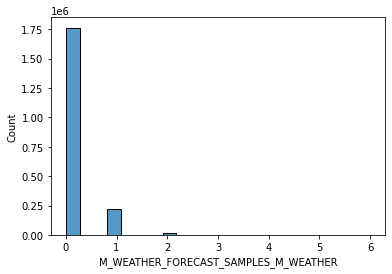

In [49]:
sns.histplot(x=df['M_WEATHER_FORECAST_SAMPLES_M_WEATHER'])

In [55]:
df[df['M_WEATHER_FORECAST_SAMPLES_M_WEATHER'] == 6].shape

(486, 20)

We can see the dataset isn't very balanced in terms of the output classes in terms of the **M_WEATHER_FORECAST_SAMPLES_M_WEATHER** variable, with the class **0 (sunny)** taking up the majority of the outputs. We also noticed that there were some rows which had the prediction set to class 6, which shouldn't exist because the documentation states that there are classes from 0 to 5. Even though it probably wouldn't make a major difference in the final predictions we are still removing those rows from the dataset as it is only 486 rows compared to a couple million.

In [56]:
df = df[df['M_WEATHER_FORECAST_SAMPLES_M_WEATHER'] != 6]
df.shape

(1995960, 20)

<AxesSubplot:xlabel='M_RAIN_PERCENTAGE', ylabel='count'>

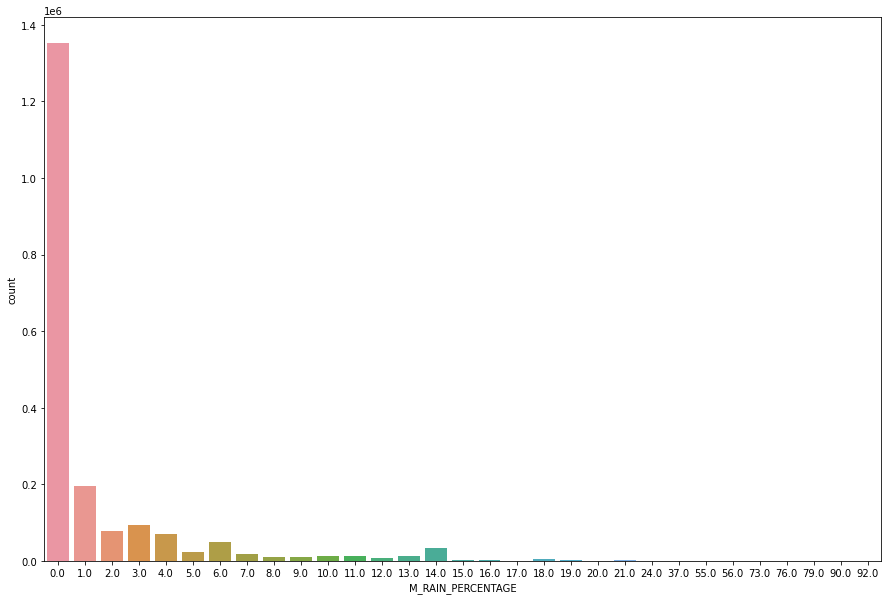

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10)) 
sns.countplot(x=df['M_RAIN_PERCENTAGE'], ax=ax)

For the **M_RAIN_PERCENTAGE** variable we can see that the data is also extremely skewed and in this case all data seems to be within bounds. We won't be removing any rows here.

### Duplicates for different players in the same session

F1 2021 game offers a lot of different game modes, which also include online multiplayer games as well as split-screen. And as we potentionally have more than one player, we need to take into consideration that every player/car will provide a packet of his own. And that means that we will receive a lot of almost identical rows, differing only in the **M_PLAYER_CAR_INDEX** values, because they will send the same package at the same timestamp, with the same forecast, same session uid, etc. That's why we decided to remove duplicates with the subset checking if a row is a duplicate is **M_SESSION_UID, TIMESTAMP, M_PLAYER_CAR_INDEX, M_TIME_OFFSET**. These 4 variables provide a unique key for each row, 3 of them are the unique key for the dataset in the JSON format, as it was noted in the dataset documentation, but we needed to add an additional variable **M_TIME_OFFSET** because the JSON format has more than one weather forecast packet inside of it, and when JSONs were flattened to CSV, 1 JSON became more rows in CSV, and we needed a unique feature to differentiate the rows from the same JSON from one another. After we removed the duplicates, we only had a need for the **M_TIME_OFFSET** variable, as all of the other ones contained in the key provided no information which would benefit forecast prediction and less columns means that the training of the models should be faster.

In [135]:
df_no_dup = df.drop_duplicates(subset =["M_SESSION_UID", "TIMESTAMP", "M_PLAYER_CAR_INDEX", "M_TIME_OFFSET"],
                     keep = "first", inplace = False)
df_no_dup = df_no_dup.drop(columns=["M_SESSION_UID", "TIMESTAMP", "M_PLAYER_CAR_INDEX"],inplace=False)
df_no_dup.shape

(260895, 17)

### Correlation plot

<AxesSubplot:>

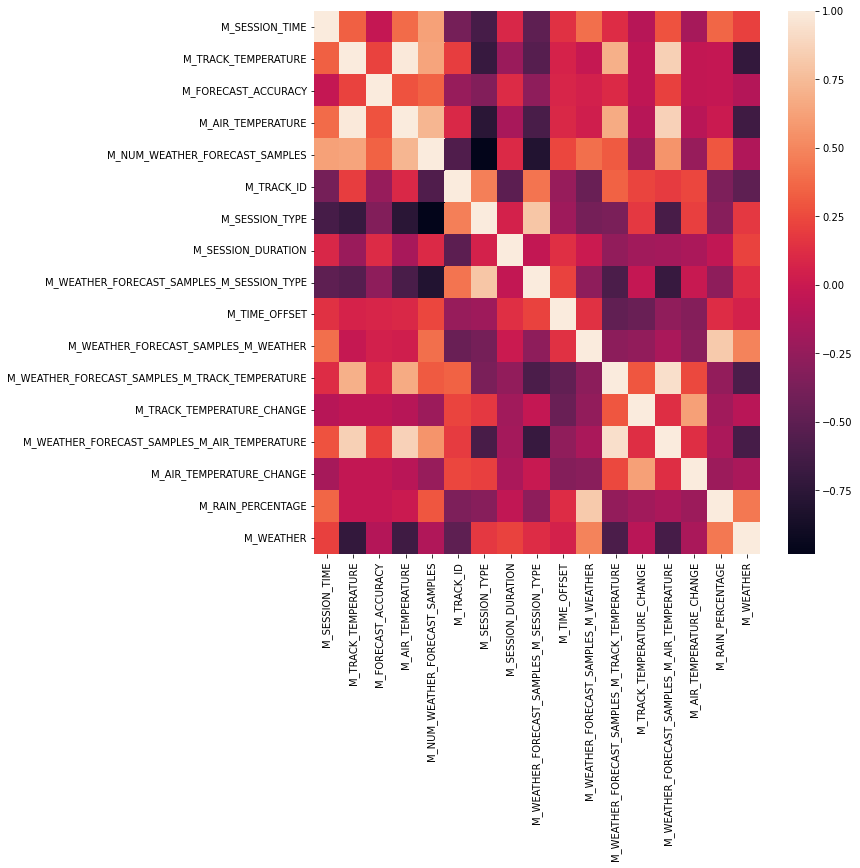

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10)) 
corr = df_no_dup.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           ax=ax)

## Classification

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

### Classification without future prediction in the input

In [159]:
df_full = df_no_dup.copy()
print(df_full.shape)

X = df_full.loc[:, ["M_WEATHER", "M_TRACK_TEMPERATURE", "M_FORECAST_ACCURACY", "M_AIR_TEMPERATURE", "M_TIME_OFFSET", "M_SESSION_TIME"]]
y = df_full.filter(items=["M_WEATHER_FORECAST_SAMPLES_M_WEATHER"])

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=2202)

(260895, 17)


#### Decision tree

In [232]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train,y_train)

y_pred = decision_tree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24452
         1.0       0.99      0.99      0.99     13531
         2.0       1.00      1.00      1.00      1080
         3.0       1.00      1.00      1.00        71
         5.0       1.00      1.00      1.00         1

    accuracy                           1.00     39135
   macro avg       1.00      1.00      1.00     39135
weighted avg       1.00      1.00      1.00     39135



#### Naive Bayes

In [165]:
naive_bayes = GaussianNB()
naive_bayes.fit(x_train,y_train)

y_pred = naive_bayes.predict(x_test)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80     24493
         1.0       0.62      0.49      0.55     13475
         2.0       0.34      0.52      0.42      1102
         3.0       0.27      1.00      0.43        65
         5.0       0.00      0.00      0.00         0

    accuracy                           0.71     39135
   macro avg       0.40      0.57      0.44     39135
weighted avg       0.70      0.71      0.70     39135



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Support Vector Classifier

In [168]:
svm = LinearSVC()
svm.fit(x_train,y_train)

y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

              precision    recall  f1-score   support

         0.0       0.65      0.99      0.78     24493
         1.0       0.55      0.07      0.12     13475
         2.0       1.00      0.00      0.01      1102
         3.0       0.00      0.00      0.00        65

    accuracy                           0.64     39135
   macro avg       0.55      0.27      0.23     39135
weighted avg       0.62      0.64      0.53     39135



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Classification using the in-game engine prediction features

In [230]:
df_full = df_no_dup.copy()
print(df_full.shape)

X = df_full.drop(columns=["M_WEATHER_FORECAST_SAMPLES_M_WEATHER", "M_RAIN_PERCENTAGE"],inplace=False)
y = df_full.filter(items=["M_WEATHER_FORECAST_SAMPLES_M_WEATHER"])
print(X.columns)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=100)

(260895, 17)
Index(['M_SESSION_TIME', 'M_TRACK_TEMPERATURE', 'M_FORECAST_ACCURACY',
       'M_AIR_TEMPERATURE', 'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_TRACK_ID',
       'M_SESSION_TYPE', 'M_SESSION_DURATION',
       'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE', 'M_TIME_OFFSET',
       'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
       'M_TRACK_TEMPERATURE_CHANGE',
       'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE',
       'M_AIR_TEMPERATURE_CHANGE', 'M_WEATHER'],
      dtype='object')


#### Decision tree

In [235]:
decision_tree_cls = DecisionTreeClassifier()
decision_tree_cls.fit(x_train,y_train)

y_pred = decision_tree_cls.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24452
         1.0       0.99      0.99      0.99     13531
         2.0       1.00      1.00      1.00      1080
         3.0       1.00      1.00      1.00        71
         5.0       1.00      1.00      1.00         1

    accuracy                           1.00     39135
   macro avg       1.00      1.00      1.00     39135
weighted avg       1.00      1.00      1.00     39135



#### Naive Bayes

In [174]:
naive_bayes = GaussianNB()
naive_bayes.fit(x_train,y_train)

y_pred = naive_bayes.predict(x_test)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87     24195
         1.0       0.70      0.83      0.76     13773
         2.0       0.45      0.87      0.59      1092
         3.0       1.00      1.00      1.00        75

    accuracy                           0.82     39135
   macro avg       0.77      0.88      0.81     39135
weighted avg       0.84      0.82      0.82     39135



#### Support Vector Classifier

In [175]:
svm = LinearSVC()
svm.fit(x_train,y_train)

y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beh

              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87     24195
         1.0       0.73      0.97      0.83     13773
         2.0       0.64      0.32      0.43      1092
         3.0       1.00      1.00      1.00        75
         5.0       0.00      0.00      0.00         0

    accuracy                           0.83     39135
   macro avg       0.67      0.61      0.63     39135
weighted avg       0.89      0.83      0.84     39135



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Regression

In [184]:
import sklearn
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

### Regression without future prediction in the input

In [180]:
df_full = df_no_dup.copy()
print(df_full.shape)

X = df_full[["M_WEATHER", "M_TRACK_TEMPERATURE", "M_FORECAST_ACCURACY", "M_AIR_TEMPERATURE", "M_TIME_OFFSET", "M_TRACK_ID"]]
y = df_full.filter(items=["M_RAIN_PERCENTAGE"])

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15)

(260895, 17)


#### Decision tree

In [234]:
decision_tree_reg = DecisionTreeRegressor(random_state = 2202)
decision_tree_reg.fit(x_train,y_train)
pred = decision_tree_reg.predict(x_test)
print(mean_absolute_error(y_test,pred))
print("R-squared score:",decision_tree_reg.score(x_test,y_test))

0.004420595374984029
R-squared score: 0.9856404585137439


#### Lasso regression

In [189]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print(mean_absolute_error(y_test,pred))
print("R-squared score:",clf.score(x_test,y_test))

2.6626860481993613
R-squared score: 0.370277883229746


#### Random forest regressor

In [190]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
print(mean_absolute_error(y_test,pred))
print("score :",dt.score(x_test,y_test))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.41372682682769946
score : 0.9403020522519664


### Regression using the in-game engine prediction features

In [206]:
df_full = df_no_dup.copy()
print(df_full.shape)

X = df_full.drop(columns=["M_WEATHER_FORECAST_SAMPLES_M_WEATHER", "M_RAIN_PERCENTAGE"], inplace=False)
y = df_full.filter(items=["M_RAIN_PERCENTAGE"])

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15)

(260895, 17)


#### Decision tree

In [207]:
dt= DecisionTreeRegressor(random_state = 2202)
dt.fit(x_train,y_train)
pred = dt.predict(x_test)
print(mean_absolute_error(y_test,pred))
print("R-squared score:",dt.score(x_test,y_test))

0.05676610340060389
R-squared score: 0.9966041363386061


#### Lasso regression

In [208]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print(mean_absolute_error(y_test,pred))
print("R-squared score:",clf.score(x_test,y_test))

2.357181227860212
R-squared score: 0.5574001463229383


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10561.724663010333, tolerance: 738.7578809302843
  positive)


#### Random forest regressor

In [209]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
print(mean_absolute_error(y_test,pred))
print("score :",dt.score(x_test,y_test))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.06526647546118068
score : 0.9966041363386061


## Generating predictions for multiple points in the future

In [308]:
def multiple_prediction(row, model_reg, model_cls):
    predictions = {}
    for offset in [5,10,15,30,60]:
        row["M_TIME_OFFSET"] = offset
        temp_row = row.copy()
        temp_row = temp_row.ravel().reshape(1, -1)
        pred_reg = model_reg.predict(temp_row)
        pred_cls = model_cls.predict(temp_row)
        predictions[str(offset)] = {'type':pred_cls[0], 'rain_percentage':pred_reg[0]}
    return predictions
      

In [309]:
multiple_prediction(x_test.iloc[10].copy(), decision_tree_reg, decision_tree_cls)

{'5': {'type': 0.0, 'rain_percentage': 0.0},
 '10': {'type': 0.0, 'rain_percentage': 0.0},
 '15': {'type': 0.0, 'rain_percentage': 0.0},
 '30': {'type': 0.0, 'rain_percentage': 0.0},
 '60': {'type': 0.0, 'rain_percentage': 0.0}}

## Exporting models to GraphWiz

In [311]:
from sklearn import tree
tree.export_graphviz(decision_tree_reg, out_file='decision_tree_reg.dot')
tree.export_graphviz(decision_tree_cls, out_file='decision_tree_cls.dot')

## API info

The API can be found here http://141.144.224.177:5000/predict and by sending a POST request containing the 14 rows we kept, you can predict your data without even running a single Jupyter cell. 
('M_SESSION_TIME', 'M_TRACK_TEMPERATURE', 'M_FORECAST_ACCURACY',
       'M_AIR_TEMPERATURE', 'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_TRACK_ID',
       'M_SESSION_TYPE', 'M_SESSION_DURATION',
       'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
       'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
       'M_TRACK_TEMPERATURE_CHANGE',
       'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE',
       'M_AIR_TEMPERATURE_CHANGE', 'M_WEATHER')

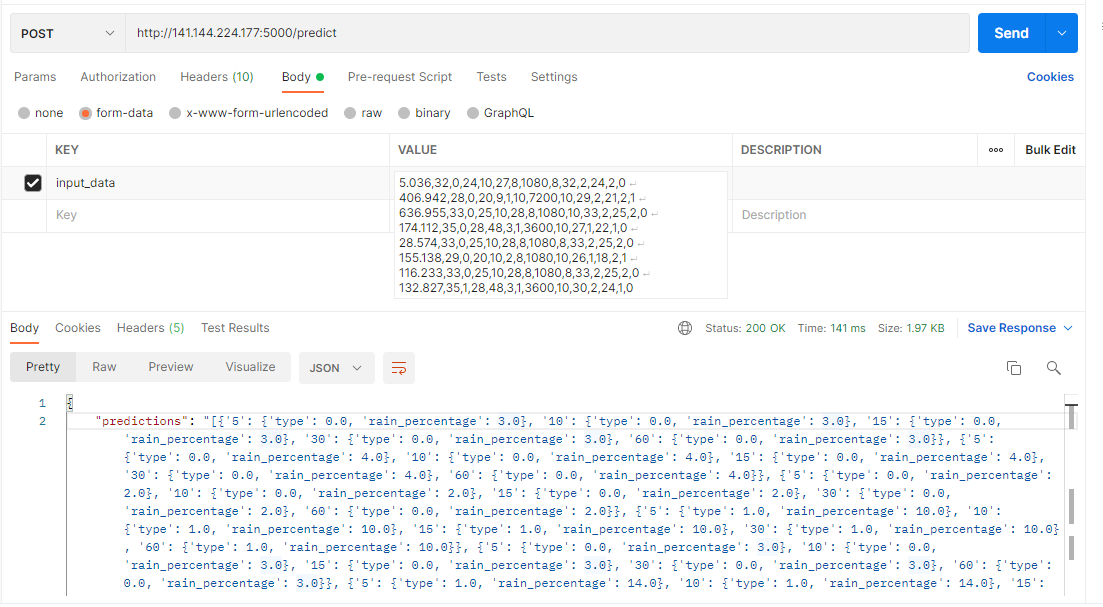